In [1]:
import pandas as pd
import numpy as np

def entropy(y):
  values, counts = np.unique(y, return_counts=True)
  probabilities = counts / counts.sum()
  return -np.sum(probabilities * np.log2(probabilities))

def information_gain(X, y, feature):
  if X[feature].dtype == object:  # Categorical Feature
    values, counts = np.unique(X[feature], return_counts=True)
    weighted_entropy = sum((counts[i] / len(y)) * entropy(y[X[feature] == values[i]]) for i in range(len(values)))
  else:  # Numerical Feature (Find Best Threshold)
    thresholds = X[feature].unique()
    best_entropy = float("inf")
    for t in thresholds:
      left_y, right_y = y[X[feature] <= t], y[X[feature] > t]
      entropy_t = (len(left_y) / len(y)) * entropy(left_y) + (len(right_y) / len(y)) * entropy(right_y)
      if entropy_t < best_entropy:
        best_entropy, best_threshold = entropy_t, t
        return entropy(y) - best_entropy, best_threshold
    return entropy(y) - weighted_entropy, None

def best_split(X, y):
  best_feature, best_threshold = None, None
  max_gain = -1
  for feature in X.columns:
    gain, threshold = information_gain(X, y, feature)
    if gain > max_gain:
      max_gain, best_feature, best_threshold = gain, feature, threshold
    return best_feature, best_threshold

def build_tree(X, y):
  if len(np.unique(y)) == 1:
    return y.iloc[0]
  if X.empty:
    return y.mode().iloc[0]

  best_feature, threshold = best_split(X, y)
  if best_feature is None:
    return y.mode().iloc[0]

  tree = {best_feature: {}}

  if threshold is None:  # Categorical Split
    for value in np.unique(X[best_feature]):
      subset_X = X[X[best_feature] == value].drop(columns=[best_feature])
      subset_y = y[X[best_feature] == value]
      tree[best_feature][value] = build_tree(subset_X, subset_y)
    else:  # Numerical Split
      left_X, right_X = X[X[best_feature] <= threshold], X[X[best_feature] > threshold]
      left_y, right_y = y[X[best_feature] <= threshold], y[X[best_feature] > threshold]
      tree[best_feature][f"≤{threshold}"] = build_tree(left_X, left_y)
      tree[best_feature][f">{threshold}"] = build_tree(right_X, right_y)

    return tree

def predict(tree, sample):
  if not isinstance(tree, dict):
    return tree
  feature = next(iter(tree))
  value = sample.get(feature)
  branches = tree[feature]

  # Numerical Split Handling
  for branch in branches:
    if "≤" in branch:
      threshold = float(branch[1:])
      return predict(branches[branch], sample) if value <= threshold else predict(branches[f">{threshold}"], sample)
    elif value in branches:
      return predict(branches[value], sample)

    return list(branches.values())[0]  # Default to first branch

# Load CSV
df = pd.read_csv("./tennis.csv")

# Assume last column is target variable
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Build Decision Tree
tree = build_tree(X, y)

# Example Prediction
sample = X.iloc[0].to_dict()
print("Predicted:", predict(tree, sample))

Predicted: no


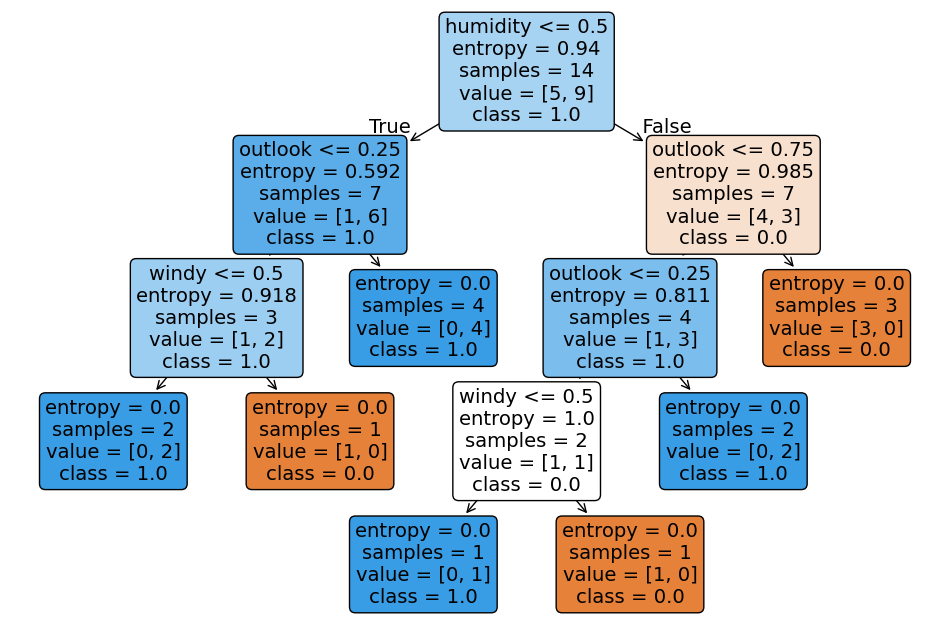

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv("./tennis.csv")

# Assume last column is the target variable
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Convert categorical variables to numerical if needed
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col])

if y.dtype == "object":  # Encode target variable if categorical
    y = LabelEncoder().fit_transform(y)

# Train Decision Tree
tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
tree.fit(X, y)

# Visualize Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.show()